# The following code is for the analysis of detecing fraud

We want to first observe methodologies of determining whether or not a given transaction is 'fraud'. There are only some possible explanations given to us, and only a select few out of these can be attmpted to be observed. 

Information can be found here:
- https://www.bluefin.com/support/identifying-fraudulent-transactions/

In [3]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.driver.memory", '4g')
    .config("spark.executor.memory", '8g')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.sql.parquet.enableVectorizedReader","false")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .getOrCreate()
)

22/09/18 01:03:48 WARN Utils: Your hostname, dash_surface resolves to a loopback address: 127.0.1.1; using 172.31.0.181 instead (on interface eth0)
22/09/18 01:03:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/18 01:03:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Read in the transactional data

In [4]:
sdf_transactions1 = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot')
sdf_transactions2 = spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot')
sdf_transactions3 = spark.read.parquet('../data/tables/transactions_20220228_20220828_snapshot')

sdf_transactions = sdf_transactions1.union(sdf_transactions2)
sdf_transactions = sdf_transactions.union(sdf_transactions3)

In [7]:
sdf_transactions.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)



### Observe if order ID is unique or not

In [5]:
sdf_transactions.count()

14195505

In [15]:
sdf_transactions.select('order_id').distinct().count()

14195505

In [16]:
sdf_transactions

user_id,merchant_abn,dollar_value,order_id,order_datetime
18478,62191208634,63.255848959735246,949a63c8-29f7-4ab...,2021-08-20
2,15549624934,130.3505283105634,6a84c3cf-612a-457...,2021-08-20
18479,64403598239,120.15860593212783,b10dcc33-e53f-425...,2021-08-20
3,60956456424,136.6785200286976,0f09c5a5-784e-447...,2021-08-20
18479,94493496784,72.96316578355305,f6c78c1a-4600-4c5...,2021-08-20
3,76819856970,448.529684285612,5ace6a24-cdf0-4aa...,2021-08-20
18479,67609108741,86.4040605836911,d0e180f0-cb06-42a...,2021-08-20
3,34096466752,301.5793450525113,6fb1ff48-24bb-4f9...,2021-08-20
18482,70501974849,68.75486276223054,8505fb33-b69a-412...,2021-08-20
4,49891706470,48.89796461900801,ed11e477-b09f-4ae...,2021-08-20


Seems like there are no order ID which are duplicated - so checking multiple purchases of the same item isn't possible.

This means that given our current data, the only possibilities of checking for fraud is when a customer makes numerous purchases in a single day, or a single purchase which is unuslaly larger than their noral purchases. We will check how this may be related and try to create some sort of heuristic.

In [5]:
from pyspark.sql import functions as F

In [6]:
user_purchase = sdf_transactions.groupBy(F.col('user_id'), F.col('order_datetime')).agg({
    'user_id': 'count'
})

In [25]:
user_purchase.count()

8976957

In [24]:
user_purchase

user_id,order_datetime,count(user_id)
18488,2021-08-20,3
686,2021-08-20,2
19292,2021-08-20,1
778,2021-08-20,2
786,2021-08-20,1
19476,2021-08-20,2
19497,2021-08-20,2
19628,2021-08-20,2
19631,2021-08-20,1
19672,2021-08-20,3


In [37]:
user_purchase.select("count(user_id)").rdd.max()[0]

12

In [39]:
user_purchase.where(F.col("count(user_id)") == 12)

user_id,order_datetime,count(user_id)
5369,2021-12-26,12


In [7]:
# Read in fraud data

fraud_sdf = spark.read.csv("../data/tables/consumer_fraud_probability.csv", header=True)

In [45]:
fraud_sdf

user_id,order_datetime,fraud_probability
6228,2021-12-19,97.6298077657765
21419,2021-12-10,99.24738020302328
5606,2021-10-17,84.05825045251777
3101,2021-04-17,91.42192091901347
22239,2021-10-19,94.70342477508035
16556,2022-02-20,89.65663294494827
10278,2021-09-28,83.59136689427714
15790,2021-12-30,71.77065889280253
5233,2021-08-29,85.87123303878818
230,2021-08-28,86.28328808934151


We take the highest probability of fraud and determine if it is related to any of the 2 initial ideas that we had

In [48]:
user_purchase.where((F.col("user_id") == 21419) & (F.col("order_datetime") == "2021-12-10"))

user_id,order_datetime,count(user_id)
21419,2021-12-10,1


In [52]:
sdf_transactions.where((F.col("user_id") == 21419) & (F.col("order_datetime") == "2021-12-10"))

user_id,merchant_abn,dollar_value,order_id,order_datetime
21419,23686790459,67706.74019097649,079cc8aa-eadd-4f3...,2021-12-10


In [55]:
sdf_transactions.where(F.col("user_id") == 21419).select(F.mean("dollar_value"))

avg(dollar_value)
302.1584895025078


In [56]:
sdf_transactions.where(F.col("user_id") == 21419).select(F.stddev("dollar_value"))

stddev_samp(dollar_value)
2851.042573410824


It appears that the probability of fraud can be possibly found by calculating the probability of an 'extreme' value of some assumed distribution as a general customer base. Thus, we will run analysis on the data we have have to determine both "outliers" which we can then convert into probabilities from that given distirbution.

We also check if fraud is detectable by a large number of purchases made by a single person over a small timeframe.

### Load in fraud data and join

In [8]:
# Rename columns to to avoid 'ambiguity'

sdf_transactions = sdf_transactions.withColumnRenamed(
    'user_id',
    'trans_user_id'
).withColumnRenamed(
    'order_datetime',
    "trans_order_datetime"
)

In [9]:
# Join fraud data with transactional data

fraud_data = fraud_sdf.join(sdf_transactions, how='left', on=((fraud_sdf.user_id == sdf_transactions.trans_user_id) & (fraud_sdf.order_datetime == sdf_transactions.trans_order_datetime)))

In [10]:
fraud_data = fraud_data.select(F.col("user_id"), F.col("order_datetime"), F.col("fraud_probability"), F.col("merchant_abn"), F.col("dollar_value"))

In [69]:
fraud_data

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
5965,2021-11-14,69.37164467869053,11149063370,43965.46355720679
22239,2021-10-19,94.70342477508035,67264251405,51876.637563877644
10897,2021-11-11,71.27699927869216,21807339153,19.468458703644316
10897,2021-11-11,71.27699927869216,19010030815,41999.00172659059
3101,2021-04-17,91.42192091901347,91880575299,105193.88578925544
6383,2021-09-15,66.2676451623754,34920839316,22.898167875482013
6383,2021-09-15,66.2676451623754,14530561097,46001.13901942742
10278,2021-09-28,83.59136689427714,19010030815,50066.19010321954
5233,2021-08-29,85.87123303878818,91720867026,17.636911995810458
5233,2021-08-29,85.87123303878818,34695415993,87.75287320319775


### Purchase frequency of 12

In [70]:
# Check 5369 with 12 purchases in 2021-12-26

fraud_data.where(F.col('user_id') == 5369)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
5369,2021-07-16,8.668932496804345,32234779638,78.3111896522116
5369,2021-07-16,8.668932496804345,24015576448,5665.42027487531
5369,2021-11-09,36.191343302316,24015576448,11789.425948910024
5369,2021-11-09,36.191343302316,69983142241,2.270540033820603
5369,2021-11-09,36.191343302316,69069584766,99.48503670679246
5369,2021-11-09,36.191343302316,46804135891,98.37758936489477


Appears to not exist, high freq can be explained by post-christmas shopping?

Further, since the highest frequency of purchased was 12 but that didn't have much fraud information, we check 11 and 10 for possible fraud detection.

### Purchase frequency of 11

In [71]:
user_purchase.where(F.col('count(user_id)') == 11)

user_id,order_datetime,count(user_id)
10326,2021-11-26,11
11958,2021-11-26,11
11002,2021-11-29,11


In [72]:
fraud_data.where(F.col('user_id') == 10326)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
10326,2021-11-26,10.362651044336713,49212265466,134.1269285376452
10326,2021-11-26,10.362651044336713,83690644458,40.904110782508475
10326,2021-11-26,10.362651044336713,15061716544,166.66009961642183
10326,2021-11-26,10.362651044336713,68501926042,134.09658628888243
10326,2021-11-26,10.362651044336713,78073971498,205.74504214676077
10326,2021-11-26,10.362651044336713,46804135891,50.868638055307194
10326,2021-11-26,10.362651044336713,60813622669,420.89337044094697
10326,2021-11-26,10.362651044336713,62787106107,994.9012691000089
10326,2021-11-26,10.362651044336713,24852446429,59.08633924393676
10326,2021-11-26,10.362651044336713,49891706470,24.98676101894532


In [73]:
fraud_data.where(F.col('user_id') == 11958)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
11958,2021-12-28,10.46037646956201,66983698186,1093.3735067543755
11958,2021-12-28,10.46037646956201,45629217853,27.62567136720168
11958,2021-12-28,10.46037646956201,49891706470,45.8145293582885
11958,2021-12-28,10.46037646956201,77037096829,180.74778494699612
11958,2021-12-28,10.46037646956201,75664480997,763.0327605057961
11958,2021-12-28,10.46037646956201,93558142492,529.4419660472563
11958,2021-11-26,13.539138238106881,45559085309,48.28926680799455
11958,2021-11-26,13.539138238106881,90692244747,189.7765381860137
11958,2021-11-26,13.539138238106881,40776514177,2441.6646776314105
11958,2021-11-26,13.539138238106881,76314317957,159.00242716710244


In [74]:
fraud_data.where(F.col('user_id') == 11002)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
11002,2021-06-18,26.61514467781595,63248668429,16061.420812765555
11002,2021-06-18,26.61514467781595,22027671078,284.0647880128037


### Purhcase frequency of 10

In [75]:
user_purchase.where(F.col('count(user_id)') == 10)

user_id,order_datetime,count(user_id)
8154,2021-11-26,10
13985,2021-11-27,10
6629,2021-11-26,10
3129,2021-11-30,10
7760,2021-11-29,10
10904,2021-11-26,10
6376,2021-11-29,10
22439,2022-10-22,10
23137,2021-11-26,10
23638,2021-11-26,10


In [76]:
fraud_data.where(F.col('user_id') == 8154)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
8154,2021-11-24,12.299875186818257,50913027463,3778.8386014332577


In [77]:
fraud_data.where(F.col('user_id') == 13985)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
13985,2021-03-16,19.385484342587592,44345785419,12272.241157945278
13985,2021-03-16,19.385484342587592,45629217853,1.2660486092350531
13985,2021-08-28,8.858905983923913,29521780474,53.48708461298834
13985,2021-08-28,8.858905983923913,14939466370,110.8907650771532
13985,2021-08-28,8.858905983923913,76078244980,2640.036126106496
13985,2021-10-12,9.924680306154238,96781066746,2879.9427384355076
13985,2021-10-12,9.924680306154238,39368471973,261.8574123280791


In [78]:
fraud_data.where(F.col('user_id') == 6629)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
6629,2021-11-16,9.787518625637492,91873181182,59.30772310737456
6629,2021-11-16,9.787518625637492,17208085375,2524.968127586685


In [79]:
fraud_data.where(F.col('user_id') == 3129)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
3129,2021-06-18,38.711053902453386,94609427687,24.237540392529773
3129,2021-06-18,38.711053902453386,19492220327,26359.935695654203
3129,2021-06-18,38.711053902453386,73804469952,53.419217647013696
3129,2021-06-18,38.711053902453386,85574524327,839.8062242376436


In [80]:
fraud_data.where(F.col('user_id') == 7760)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
7760,2021-05-30,10.287848217893623,10553813474,685.6180985215592
7760,2021-05-30,10.287848217893623,79417999332,49.68157686030487
7760,2021-05-30,10.287848217893623,59258669983,6364.953187356746
7760,2021-08-05,11.337519569164382,28767881738,7640.509350931848
7760,2021-08-05,11.337519569164382,14583462783,184.1838280851497
7760,2021-09-10,15.472977886116244,49505931725,233.49968388633187
7760,2021-09-10,15.472977886116244,75892370170,4774.759565278814
7760,2021-09-10,15.472977886116244,24471518053,182.50986897704533
7760,2021-09-10,15.472977886116244,99022808555,148.63972635773575


In [81]:
fraud_data.where(F.col('user_id') == 10904)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
10904,2021-11-26,9.18446165409599,69108448846,501.6658704429282
10904,2021-11-26,9.18446165409599,64403598239,83.56050775803784
10904,2021-11-26,9.18446165409599,44631836704,165.05357225929762
10904,2021-11-26,9.18446165409599,13118172970,95.88121771628131
10904,2021-11-26,9.18446165409599,88553358884,264.2523935932471
10904,2021-11-26,9.18446165409599,58321530622,339.49161015530603
10904,2021-11-26,9.18446165409599,92980848589,349.62560768274557
10904,2021-11-26,9.18446165409599,76323008415,943.1939680723254
10904,2021-11-26,9.18446165409599,15903176024,237.43521264660149
10904,2021-11-26,9.18446165409599,24852446429,18.136592883487193


In [82]:
fraud_data.where(F.col('user_id') == 6376)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value


In [83]:
fraud_data.where(F.col('user_id') == 22439)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
22439,2022-01-01,14.500993608550584,20269486864,4134.732540496104


In [84]:
fraud_data.where(F.col('user_id') == 23137)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
23137,2021-11-26,17.178119061117922,96146457679,23.493416071205736
23137,2021-11-26,17.178119061117922,17324645993,0.9948614582795873
23137,2021-11-26,17.178119061117922,68483735536,14.682537928742864
23137,2021-11-26,17.178119061117922,10023283211,732.5092004890014
23137,2021-11-26,17.178119061117922,46331355995,958.1369389868084
23137,2021-11-26,17.178119061117922,28057731482,1140.9930568533246
23137,2021-11-26,17.178119061117922,55955609006,115.80250995180677
23137,2021-11-26,17.178119061117922,33412969398,1062.5037754705343
23137,2021-11-26,17.178119061117922,11240426404,242.0153423853247
23137,2021-11-26,17.178119061117922,76626119831,124.39398050461146


In [85]:
fraud_data.where(F.col('user_id') == 23638)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
23638,2021-12-05,12.445232870455428,35911782646,2851.0736441583886
23638,2021-12-05,12.445232870455428,89518629617,17.04000551694936


As we can see, the probability of fraud for multiple purchases in the same day doesn't seem to be very high. Thus, it would be enough to check for high dollar values in purhcases from a given distribution for any given customer rather than checking for frequency of purchases.

As mentioned previously, this may be attributed to customers having random spikes in their purchases due to the nature of the day - boxing day, black friday and many more days where a high purchase frequency would be reasonable. Thus, it should be safe to ignore this as a factor as fraud.

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
x = fraud_data.select(F.col("dollar_value"))
y = fraud_data.select(F.col("fraud_probability"))
hist_data = fraud_data.select(F.col('dollar_value'), F.col('fraud_probability'))

In [13]:
hist_df = hist_data.toPandas()
x_list = x.toPandas()['dollar_value'].values.tolist()
y_list = y.toPandas()['fraud_probability'].values.tolist()

In [15]:
hist_df.dropna(inplace=True)

(1.0, 10000.0)

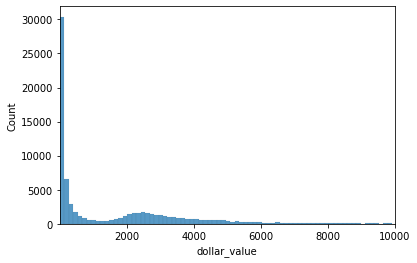

In [32]:
fig = sns.histplot(hist_df.dollar_value)

fig.set_xlim(1, 10000) # We set limit since the majority of our dollar values are less than $10000

There doesn't seem to be a relationship bewteen higher dollar value and fraud probability?

In [25]:
fraud_data.where(F.col("fraud_probability") > 90)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
8347,2021-10-06,92.99138306039121,73972053940,13.807156691382522
8347,2021-10-06,92.99138306039121,23686790459,40317.45505936584
8347,2021-10-06,92.99138306039121,73972053940,13.807156691382522
8347,2021-10-06,92.99138306039121,23686790459,40317.45505936584
22239,2021-10-19,94.70342477508035,67264251405,51876.637563877644
22239,2021-10-19,94.70342477508035,67264251405,51876.637563877644
3101,2021-04-17,91.42192091901347,91880575299,105193.88578925544
6228,2021-12-19,97.6298077657765,49549583265,1682.693398737649
6228,2021-12-19,97.6298077657765,82999039227,77320.86980270348
6228,2021-12-19,97.6298077657765,21025433654,2.7444223963251986


Given that we say that 70% fraud is considered high enough as the cutoff, we consider what is an 'extreme' value

In [34]:
fraud_data.where((F.col("fraud_probability") > 70) & (F.col("dollar_value") > 20000) & (F.col("dollar_value") < 30000))

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
22982,2021-11-29,79.5097014466787,78118727544,29782.46283433956
22982,2021-11-29,79.5097014466787,78118727544,29782.46283433956
761,2021-11-27,74.15534349046963,88040874613,28660.98021408071
11145,2021-11-30,74.43663883233376,79070032105,26164.71598795186
4615,2021-12-10,71.1922274619567,29215623643,22970.60520814089
24041,2021-12-15,74.8982837932529,69184324876,29918.278102471766
1886,2021-11-13,72.44040131522998,31334588839,29174.929747379138
20188,2021-12-28,71.29598863091222,13289167958,27662.657444808836
17281,2021-10-28,75.83080516549336,35575706403,29852.89707035264
6661,2021-09-02,71.7714810710456,97590358496,28378.248111680907


In [33]:
fraud_data.where((F.col("fraud_probability") > 70) & (F.col("dollar_value") > 10000) & (F.col("dollar_value") < 20000))

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value


It appears that there is nothing below $20000 in a single purchase that is considered more than 70% fraud, so we take $20000 as the lowest for visualisations

In [43]:
i = 0
x = []
y = []

while i < len(x_list):
    if x_list[i] > 20000:
        x.append(x_list.pop(i))
        y.append(y_list.pop(i))

    i += 1

Text(0, 0.5, 'Fraud probability')

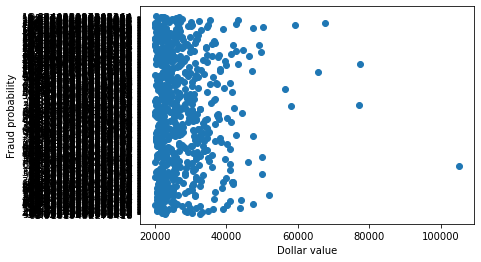

In [46]:
plt.scatter(x, y)
plt.xlabel("Dollar value")
plt.ylabel("Fraud probability")

There doesn't seem to be much trend between dollar value spent and increasing probability however. We confirm that this is actually possible

In [47]:
fraud_data.where((F.col("fraud_probability") < 70) & (F.col("dollar_value") > 20000) )

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
135,2021-08-21,30.69621736051136,58830373879,20634.537351094226
4205,2021-08-21,35.858612553,72058040180,22149.60193906642
18389,2021-08-21,49.30985454752586,58495294020,35039.06026078579
12865,2021-08-19,35.081845582853106,67213521157,21808.25111679347
11970,2021-08-22,39.318427277172255,82999039227,25667.009075814098
1007,2021-08-14,42.146037814337866,79100970961,24856.843234929504
8163,2021-08-14,36.55555808898818,29215623643,23374.807570058147
11389,2021-08-14,26.63319050402645,64701685993,21103.889985406404
12053,2021-08-14,38.61206521933114,31334588839,25448.89601968317
11568,2021-08-16,41.35595994786046,11590404675,32972.12363252083


In [48]:
fraud_data.where(F.col("user_id") == 135)

user_id,order_datetime,fraud_probability,merchant_abn,dollar_value
135,2021-08-21,30.69621736051136,52959528548,84.22049822506577
135,2021-08-21,30.69621736051136,81219314324,42.81484805566927
135,2021-08-21,30.69621736051136,58830373879,20634.537351094226
135,2021-12-07,11.439527398948597,67978471888,464.36221884307724
135,2021-12-07,11.439527398948597,15069598461,50.08283894640252
135,2021-12-07,11.439527398948597,51479541036,3354.151794512186


In [49]:
fraud_data.where(F.col("user_id") == 135).select(F.mean("dollar_value"))

avg(dollar_value)
4105.028258279438


In [50]:
fraud_data.where(F.col("user_id") == 135).select(F.stddev("dollar_value"))

stddev_samp(dollar_value)
8199.438891915433


In [52]:
# Mean of user 135 without 'outlier'

(84.22+42.81+464.36+50.08+3354.15)/5

799.124

In [54]:
# Stddev of user 135 without 'outlier'

(((84.22-799.12)**2 + (42.81-799.12)**2 + (464.36-799.12)**2 + (50.08-799.12)**2 + (3354.15-799.12)**2)/4)**(1/2)

1439.130840663906

## Feature engineering

The possible features that we came up with are:
1. Revenue band levels per transaction
2. Difference in purchase amount from a customer's 'average' spending
3. A customer who usually doesn't purchase much buying items very frequently